# Whatpulse Keypress Counter

By Kenneth Burchfiel

Released under the MIT license

This program reads Whatpulse keypress data (stored in local SQLite databases); combines that data into a single Pandas DataFrame; and then performs analyses on that data.

More documentation/explanation of the code will be provided in the future.

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
current_computer_nickname = 'ga15pyd' # Used for naming .csv files

database_paths_list = ['C:\\Users\\kburc\\AppData\\Local\\whatpulse\\whatpulse.db', 'C:\\Users\\kburc\\D1V1\\Documents\\whatpulse_database_backups\\a13r2_whatpulse.db'] # Necessary to escape the backslashes

In [3]:
def analyze_keypresses(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses.drop('hour',axis=1,inplace=True)    
    df_daily_keypresses = df_keypresses.groupby('day').sum()
    if '0000-00-00' in df_daily_keypresses.index:
        df_daily_keypresses.drop('0000-00-00',inplace=True)
    df_daily_keypresses.rename(columns={'count':'keypresses'},inplace=True)    
    df_daily_keypresses.sort_values('day',inplace=True)
    df_daily_keypresses['source'] = database_path.split('\\')[-1]
    print("\nNow analyzing", database_path.split('\\')[-1]+":")
    print("Total keypresses so far with this computer:",sum(df_daily_keypresses['keypresses']))
    print("Maximum keypresses in one day with this computer:",max(df_daily_keypresses['keypresses']))
    print("Average daily keypresses (at least for days with 1 or more keypresses):",np.mean(df_daily_keypresses['keypresses']))
    # plt.plot(df_daily_keypresses['keypresses'])
    return df_daily_keypresses

In [4]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(analyze_keypresses(path))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)
df_combined_daily_keypresses = df_combined_daily_keypresses.groupby('day').sum() # This gets rid of the 'source' column, but that's OK, since this line is necessary to adjust for days where multiple computers were used.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses



Now analyzing whatpulse.db:
Total keypresses so far with this computer: 11644217
Maximum keypresses in one day with this computer: 73788
Average daily keypresses (at least for days with 1 or more keypresses): 24565.85864978903

Now analyzing a13r2_whatpulse.db:
Total keypresses so far with this computer: 8493955
Maximum keypresses in one day with this computer: 77753
Average daily keypresses (at least for days with 1 or more keypresses): 30775.19927536232
744


,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2022-11-09,53965
2022-11-10,41626
2022-11-11,2417


The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses).

In [5]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0) # See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
df_combined_daily_keypresses.index.name = 'Date'
df_combined_daily_keypresses.reset_index(inplace=True) 

In [6]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['28_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(28).mean() 
# I switched from a 30-day MA to a 28-day MA because my average keypresses vary significantly by weekday, meaning
# that a 30-day average would be skewed by the number of Saturdays and Sundays present in the data.
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses['keypresses'].rank(pct=True)
df_combined_daily_keypresses['rank'] = df_combined_daily_keypresses['keypresses'].rank(ascending = False)
df_combined_daily_keypresses

785


,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank
0,2020-09-21,19081,NaN,NaN,NaN,38.853503,481.0
1,2020-09-22,32771,NaN,NaN,NaN,65.605096,271.0
2,2020-09-23,32065,NaN,NaN,NaN,64.203822,282.0
3,2020-09-24,34698,NaN,NaN,NaN,68.089172,251.5
4,2020-09-25,47038,NaN,NaN,NaN,86.624204,106.0
...,...,...,...,...,...,...,...
780,2022-11-10,41626,31468.857143,25533.857143,20443.989041,79.745223,160.0
781,2022-11-11,2417,27233.285714,25263.000000,20378.558904,13.375796,681.0
782,2022-11-12,0,25192.714286,25207.857143,20279.197260,2.802548,764.0
783,2022-11-13,23870,27799.857143,26060.357143,20248.641096,47.643312,412.0


Adding in weekdays:

In [7]:
df_weekday_mapping = pd.DataFrame({"Number":[0, 1, 2, 3, 4, 5, 6], "Weekday":["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]})
# Weekday numbers in Python begin with 0 for Monday and end with 6 for Sunday. See https://docs.python.org/3/library/datetime.html#datetime.date.weekday
df_weekday_mapping

,Number,Weekday
0,0,Monday
1,1,Tuesday
2,2,Wednesday
3,3,Thursday
4,4,Friday
5,5,Saturday
6,6,Sunday


In [8]:
df_combined_daily_keypresses['weekday_num'] = df_combined_daily_keypresses['Date'].dt.weekday.copy()
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,weekday_num
0,2020-09-21,19081,NaN,NaN,NaN,38.853503,481.0,0
1,2020-09-22,32771,NaN,NaN,NaN,65.605096,271.0,1
2,2020-09-23,32065,NaN,NaN,NaN,64.203822,282.0,2
3,2020-09-24,34698,NaN,NaN,NaN,68.089172,251.5,3
4,2020-09-25,47038,NaN,NaN,NaN,86.624204,106.0,4
...,...,...,...,...,...,...,...,...
780,2022-11-10,41626,31468.857143,25533.857143,20443.989041,79.745223,160.0,3
781,2022-11-11,2417,27233.285714,25263.000000,20378.558904,13.375796,681.0,4
782,2022-11-12,0,25192.714286,25207.857143,20279.197260,2.802548,764.0,5
783,2022-11-13,23870,27799.857143,26060.357143,20248.641096,47.643312,412.0,6


In [9]:
df_combined_daily_keypresses = df_combined_daily_keypresses.merge(df_weekday_mapping, left_on = 'weekday_num', right_on = 'Number', how = 'left')
# If the 'how' field is left blank, the resulting DataFrame will be sorted by weekday instead of by date.
# Sorting by the Date column is necessary here since the merge operation sorted the data by 
df_combined_daily_keypresses.drop(['weekday_num', 'Number'], axis = 1, inplace = True)
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,2020-09-21,19081,NaN,NaN,NaN,38.853503,481.0,Monday
1,2020-09-22,32771,NaN,NaN,NaN,65.605096,271.0,Tuesday
2,2020-09-23,32065,NaN,NaN,NaN,64.203822,282.0,Wednesday
3,2020-09-24,34698,NaN,NaN,NaN,68.089172,251.5,Thursday
4,2020-09-25,47038,NaN,NaN,NaN,86.624204,106.0,Friday
...,...,...,...,...,...,...,...,...
780,2022-11-10,41626,31468.857143,25533.857143,20443.989041,79.745223,160.0,Thursday
781,2022-11-11,2417,27233.285714,25263.000000,20378.558904,13.375796,681.0,Friday
782,2022-11-12,0,25192.714286,25207.857143,20279.197260,2.802548,764.0,Saturday
783,2022-11-13,23870,27799.857143,26060.357143,20248.641096,47.643312,412.0,Sunday


Summary daily keypress data statistics:

In [10]:
df_combined_daily_keypresses['keypresses'].describe()

count      785.000000
mean     25653.722293
std      18092.597004
min          0.000000
25%       9836.000000
50%      25084.000000
75%      38647.000000
max      77753.000000
Name: keypresses, dtype: float64

In [11]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
775,2022-11-05,14284,26662.571429,24943.714286,20507.758904,30.828025,544.0,Saturday
776,2022-11-06,5620,26758.000000,24874.535714,20443.230137,17.834395,646.0,Sunday
777,2022-11-07,35930,27395.428571,25186.464286,20535.597260,70.700637,231.0,Monday
778,2022-11-08,36791,27217.714286,25112.857143,20486.873973,72.356688,218.0,Tuesday
779,2022-11-09,53965,31403.428571,26115.571429,20432.564384,92.484076,60.0,Wednesday
780,2022-11-10,41626,31468.857143,25533.857143,20443.989041,79.745223,160.0,Thursday
781,2022-11-11,2417,27233.285714,25263.000000,20378.558904,13.375796,681.0,Friday
782,2022-11-12,0,25192.714286,25207.857143,20279.197260,2.802548,764.0,Saturday
783,2022-11-13,23870,27799.857143,26060.357143,20248.641096,47.643312,412.0,Sunday
784,2022-11-14,28762,26775.857143,26654.464286,20324.087671,58.471338,327.0,Monday


The following cell calculates my top 50 one-day keypress totals.

In [12]:
df_max_keypresses = df_combined_daily_keypresses.sort_values('keypresses', ascending = False).reset_index(drop=True)
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
df_max_keypresses.head(50)

,Rank,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,1,2021-02-22,77753,47983.000000,41390.857143,NaN,100.000000,1.0,Monday
1,2,2020-11-23,76313,50377.571429,39924.107143,NaN,99.872611,2.0,Monday
2,3,2020-11-19,75444,47285.571429,37945.892857,NaN,99.745223,3.0,Thursday
3,4,2021-11-09,73788,37843.285714,30462.071429,29584.802740,99.617834,4.0,Tuesday
4,5,2022-05-03,72910,30511.428571,28489.285714,24401.624658,99.490446,5.0,Tuesday
5,6,2021-02-08,70591,30177.428571,34437.357143,NaN,99.363057,6.0,Monday
6,7,2021-04-06,68313,40455.857143,40719.178571,NaN,99.235669,7.0,Tuesday
7,8,2021-02-15,67930,46174.571429,40268.535714,NaN,99.108280,8.0,Monday
8,9,2020-11-30,67533,20747.428571,36843.714286,NaN,98.980892,9.0,Monday
9,10,2021-02-17,67505,45946.571429,40801.607143,NaN,98.853503,10.0,Wednesday


<BarContainer object of 50 artists>

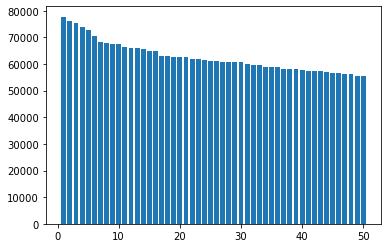

In [13]:
plt.bar(x = df_max_keypresses.head(50)['Rank'], height= df_max_keypresses.head(50)['keypresses'])

In [14]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank
count,785.000000,779.000000,758.000000,421.000000,785.000000,785.000000
mean,25653.722293,25654.218045,25445.949020,25169.115420,50.063694,393.000000
std,18092.597004,10549.207835,7849.710226,2963.406526,28.883521,226.735637
min,0.000000,0.000000,8775.535714,20248.641096,2.802548,1.000000
25%,9836.000000,18217.142857,19869.491071,23087.383562,25.095541,197.000000
50%,25084.000000,26323.428571,24857.142857,24167.964384,50.063694,393.000000
75%,38647.000000,33137.928571,31625.508929,28067.487671,75.031847,589.000000
max,77753.000000,50377.571429,41579.714286,30033.476712,100.000000,764.000000


In [15]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      785.000000
mean     25653.722293
std      18092.597004
min          0.000000
50%      25084.000000
90%      50100.200000
91%      51504.520000
92%      53224.120000
93%      54596.080000
94%      56290.880000
95%      57809.200000
96%      59653.080000
97%      61313.760000
98%      63700.680000
99%      67596.520000
100%     77753.000000
max      77753.000000
Name: keypresses, dtype: float64

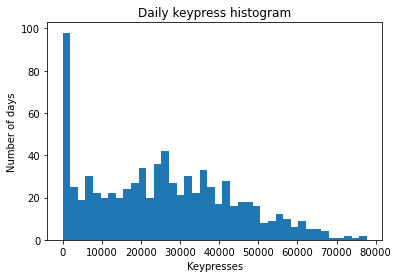

In [16]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 40)
plt.xlabel('Keypresses')
plt.ylabel('Number of days')
plt.title('Daily keypress histogram')
plt.savefig('graphs\\keypress_histogram.png')

In [17]:
df_weekday_pivot = df_combined_daily_keypresses.pivot_table(index = 'Weekday', values = 'keypresses', aggfunc = 'mean').sort_values('keypresses', ascending = False).reset_index()
df_weekday_pivot

,Weekday,keypresses
0,Tuesday,33886.803571
1,Monday,32842.495575
2,Thursday,31874.383929
3,Wednesday,30414.919643
4,Friday,24409.071429
5,Saturday,14115.178571
6,Sunday,11969.017857


In [18]:
# The following line makes the Weekday column categorical so that it can be 
# sorted in a custom order (which I specify in the 'categories' parameter). 
# See https://pandas.pydata.org/docs/user_guide/categorical.html
df_weekday_pivot['Weekday'] = pd.Categorical(df_weekday_pivot['Weekday'], 
categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
'Thursday', 'Friday', 'Saturday'], ordered = True)

In [19]:
df_weekday_pivot.sort_values('Weekday', inplace = True)
df_weekday_pivot

,Weekday,keypresses
6,Sunday,11969.017857
1,Monday,32842.495575
0,Tuesday,33886.803571
3,Wednesday,30414.919643
2,Thursday,31874.383929
4,Friday,24409.071429
5,Saturday,14115.178571


Graphing my average keypresses per weekday:

In [20]:
df_weekday_pivot

,Weekday,keypresses
6,Sunday,11969.017857
1,Monday,32842.495575
0,Tuesday,33886.803571
3,Wednesday,30414.919643
2,Thursday,31874.383929
4,Friday,24409.071429
5,Saturday,14115.178571


The following cell creates a series of colors that will be used as the bar labels for each weekday. Weekdays with more keypresses will be bluer, and weekdays with fewer keypresses will be grayer.

In [21]:
max_weekday_keypresses = max(df_weekday_pivot['keypresses'])
min_weekday_keypresses = min(df_weekday_pivot['keypresses'])
# The following line designates the colors as (r, g, b) tuples. r and g are always set to 0.5. b will be 0.5 on the day with the fewest keypresses and 1 on the day with the most keypresses.
bar_color_list = [(0.5, 0.5, 0.5 + 0.5*(keypress_value - min_weekday_keypresses)/(max_weekday_keypresses - min_weekday_keypresses)) for keypress_value in df_weekday_pivot['keypresses']]
bar_color_list

[(0.5, 0.5, 0.5),
 (0.5, 0.5, 0.9761766993750955),
 (0.5, 0.5, 1.0),
 (0.5, 0.5, 0.920797566555537),
 (0.5, 0.5, 0.9540916297592626),
 (0.5, 0.5, 0.7837890134887191),
 (0.5, 0.5, 0.5489593415653954)]

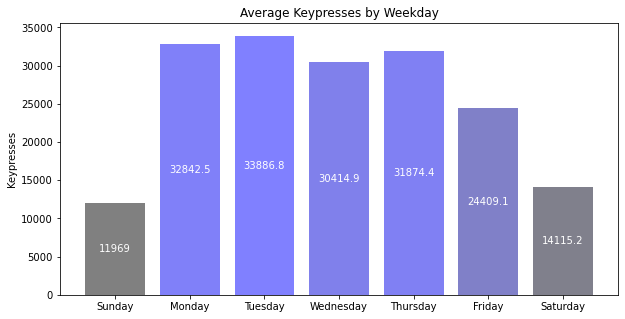

In [22]:
fig, ax = plt.subplots(figsize = [10, 5])
fig.set_facecolor('white')
bc = ax.bar(x = df_weekday_pivot['Weekday'], height = df_weekday_pivot['keypresses'], color = bar_color_list) # bc stands for 'bar container'
ax.bar_label(bc, label_type = 'center', color = 'white') 
plt.title("Average Keypresses by Weekday")
plt.ylabel("Keypresses")
# See https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
plt.savefig('graphs\\average_keypresses_by_weekday.png', dpi=400)

In [23]:
print("Total keypresess since", str(df_combined_daily_keypresses.iloc[0]['Date'])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 20,138,172


In [24]:
df_combined_daily_keypresses.tail(50) # Last 50 days

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
735,2022-09-26,20895,11148.000000,11078.785714,21719.693151,41.910828,457.0,Monday
736,2022-09-27,33433,15046.142857,11129.892857,21631.936986,65.987261,268.0,Tuesday
737,2022-09-28,29908,18806.000000,11800.107143,21618.230137,60.382166,312.0,Wednesday
738,2022-09-29,163,18692.571429,10974.107143,21466.698630,6.878981,732.0,Thursday
739,2022-09-30,0,16941.714286,10922.071429,21341.410959,2.802548,764.0,Friday
740,2022-10-01,0,15413.428571,10922.071429,21219.468493,2.802548,764.0,Saturday
741,2022-10-02,10006,13486.428571,11279.428571,21198.106849,25.477707,586.0,Sunday
742,2022-10-03,30750,14894.285714,12330.785714,21237.657534,61.656051,302.0,Monday
743,2022-10-04,34729,15079.428571,13571.107143,21197.298630,68.280255,250.0,Tuesday
744,2022-10-05,32252,15414.285714,14145.392857,21122.616438,65.095541,275.0,Wednesday


# (See above for recent keypress stats)

In [25]:
days_with_data = len(df_combined_daily_keypresses)
#  The following column cell shows the ranks immediately above the ranks for the most recent day.
keypresses_today = df_combined_daily_keypresses.iloc[-1]['keypresses']
percentile_today = df_combined_daily_keypresses.iloc[-1]['percentile']
rank_today = df_combined_daily_keypresses.iloc[-1]['rank']
print("Ranks are out of", days_with_data, "days.")
print(f"Today's keypresses: {keypresses_today}")
print(f"Today's percentile: {percentile_today}")
print(f"Today's rank: {rank_today} (in front of {days_with_data - rank_today} days)")
print("Days ranked just ahead of today:")
df_combined_daily_keypresses.sort_values('rank').query("rank < @rank_today").tail(10)

Ranks are out of 785 days.
Today's keypresses: 28762
Today's percentile: 58.47133757961783
Today's rank: 327.0 (in front of 458.0 days)
Days ranked just ahead of today:


,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
518,2022-02-21,29610,18278.857143,18395.035714,26054.712329,59.745223,317.0,Monday
644,2022-06-27,29526,10797.571429,12429.428571,23380.972603,59.617834,318.0,Monday
411,2021-11-06,29173,20727.571429,31642.142857,29458.400000,59.490446,319.0,Saturday
193,2021-04-02,29135,42782.857143,39228.464286,NaN,59.363057,320.0,Friday
280,2021-06-28,29133,24194.857143,20171.857143,NaN,59.235669,321.0,Monday
153,2021-02-21,29024,46579.714286,40931.928571,NaN,59.108280,322.0,Sunday
300,2021-07-18,29008,28967.571429,25012.892857,NaN,58.980892,323.0,Sunday
251,2021-05-30,28997,31165.857143,24705.000000,NaN,58.853503,324.0,Sunday
148,2021-02-16,28789,43452.714286,40228.071429,NaN,58.726115,325.0,Tuesday
235,2021-05-14,28767,26311.142857,20728.392857,NaN,58.598726,326.0,Friday


Looking for days with identical keypress totals:

In [26]:
df_combined_daily_keypresses[df_combined_daily_keypresses.duplicated(subset = 'keypresses', keep = False)].query('keypresses > 0').sort_values('keypresses', ascending = False)

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
32,2020-10-23,48908,41125.571429,37996.178571,NaN,88.853503,88.5,Friday
183,2021-03-23,48908,36708.000000,32516.464286,NaN,88.853503,88.5,Tuesday
3,2020-09-24,34698,NaN,NaN,NaN,68.089172,251.5,Thursday
124,2021-01-23,34698,34726.428571,24214.178571,NaN,68.089172,251.5,Saturday
318,2021-08-05,32184,29066.857143,29787.500000,NaN,64.777070,277.5,Thursday
676,2022-07-29,32184,26384.571429,26299.000000,23180.561644,64.777070,277.5,Friday
687,2022-08-09,26905,21784.571429,25372.785714,22972.580822,54.713376,356.5,Tuesday
765,2022-10-26,26905,25745.714286,20627.357143,20359.476712,54.713376,356.5,Wednesday
55,2020-11-15,26550,36325.285714,35269.428571,NaN,53.694268,364.5,Sunday
645,2022-06-28,26550,12407.857143,12670.821429,23373.895890,53.694268,364.5,Tuesday


In [27]:
# Total keypresses during MBA:

sum(df_combined_daily_keypresses.query(
    "Date >= '2020-08-20' & Date <= '2022-05-04'")['keypresses'])

16377578

In [28]:
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,2020-09-21,19081,NaN,NaN,NaN,38.853503,481.0,Monday
1,2020-09-22,32771,NaN,NaN,NaN,65.605096,271.0,Tuesday
2,2020-09-23,32065,NaN,NaN,NaN,64.203822,282.0,Wednesday
3,2020-09-24,34698,NaN,NaN,NaN,68.089172,251.5,Thursday
4,2020-09-25,47038,NaN,NaN,NaN,86.624204,106.0,Friday
...,...,...,...,...,...,...,...,...
780,2022-11-10,41626,31468.857143,25533.857143,20443.989041,79.745223,160.0,Thursday
781,2022-11-11,2417,27233.285714,25263.000000,20378.558904,13.375796,681.0,Friday
782,2022-11-12,0,25192.714286,25207.857143,20279.197260,2.802548,764.0,Saturday
783,2022-11-13,23870,27799.857143,26060.357143,20248.641096,47.643312,412.0,Sunday


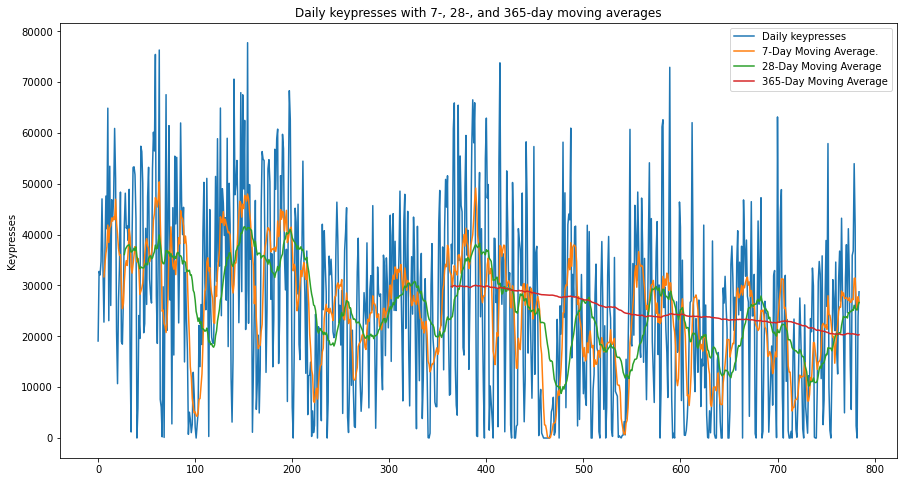

In [29]:
fig, axes = plt.subplots(figsize=[15,8])
fig.set_facecolor('white')

axes.plot(df_combined_daily_keypresses['keypresses'],label='Daily keypresses')
axes.plot(df_combined_daily_keypresses['7_day_ma'],label='7-Day Moving Average.')
axes.plot(df_combined_daily_keypresses['28_day_ma'],label='28-Day Moving Average')
axes.plot(df_combined_daily_keypresses['365_day_ma'],label='365-Day Moving Average')
plt.ylabel('Keypresses')
plt.legend()
plt.title('Daily keypresses with 7-, 28-, and 365-day moving averages')
plt.savefig('graphs\\daily_keypresses_and_MAs.png', dpi=400)

In [30]:
test_df = df_combined_daily_keypresses.copy()

In [31]:
df_monthly_keypresses = test_df.set_index('Date').resample('M').sum()['keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['keypresses'] = df_monthly_keypresses.pop('keypresses')
df_monthly_keypresses

,Month,Year,keypresses
0,2020-09,2020,346918
1,2020-10,2020,1140421
2,2020-11,2020,1061614
3,2020-12,2020,823763
4,2021-01,2021,980116
5,2021-02,2021,1088404
6,2021-03,2021,1142850
7,2021-04,2021,833464
8,2021-05,2021,700155
9,2021-06,2021,621894


The following code shows my monthly keypresses from October to April during my 2-year MBA program.

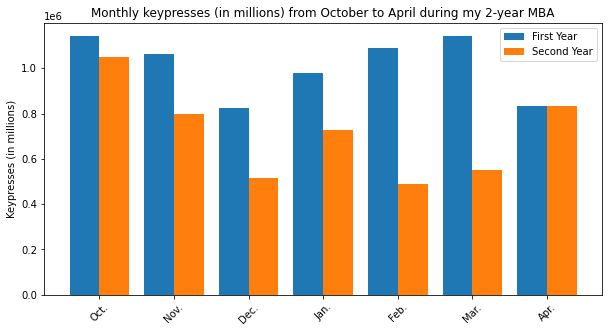

In [32]:
fig, axes = plt.subplots(figsize=[10, 5])
fig.set_facecolor('white')
# Much of the following code was based on:
# https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html
df_first_year = df_monthly_keypresses.query("Month >= '2020-10' & Month <= '2021-04'").copy()
df_second_year = df_monthly_keypresses.query("Month >= '2021-10' & Month <= '2022-04'").copy()
width = 0.4
x = np.arange(len(df_first_year))
axes.bar(x = x - width/2, height = df_first_year['keypresses'], label = 'First Year', width = width)
axes.bar(x = x + width/2, height = df_second_year['keypresses'], label = 'Second Year', width = width)
axes.set_xticks(x, ['Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.'], rotation = 45)
plt.legend()
plt.ylabel('Keypresses (in millions)')
plt.title('Monthly keypresses (in millions) from October to April during my 2-year MBA')
plt.savefig('graphs\\monthly_keypresses_during_MBA.png', dpi=400)

List of tables in each WhatPulse database file:

In [33]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [34]:
df_combined_daily_keypresses.to_csv('whatpulse_daily_keypresses.csv')

In [35]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


Completed run at Mon Nov 14 21:34:41 2022 (local time)
Total run time: 6.28 second(s) (0.0 minute(s) and 6.28 second(s))
